In [119]:
import numpy as np
import pyvisa
import time
import matplotlib.pyplot as plt
import csv

In [ ]:
class RP7972A():
    """Esta clase pide y mide los datos de la fuente, para luego ser procesados"""
    def __init__(self, curr_initialFreq, curr_finalFreq, points_per_decade, curr_amplitude, rp_USB=None):
        """Define variables de entrada como variables globales en la clase"""
        self.curr_initialFreq = curr_initialFreq
        self.curr_finalFreq = curr_finalFreq
        self.curr_amplitude = curr_amplitude
        self.curr_Freqs = [] #an array of the frequencies used for the sweep
        self.points_per_decade = points_per_decade # the points per decade to generate the frequencies for the sweep

        self.rp_USB=rp_USB
        # FOR INITIALIZATION OF POWER SOURCE (RP7972A)
        rm = pyvisa.ResourceManager()
        devices = rm.list_resources()

        print("Searching for devices...")
        if devices:
            for device in devices:
                try:
                    my_instrument = rm.open_resource(str(device))
                    device_ID=my_instrument.query('*IDN?')
                    if  "RP797" in device_ID:#if the RP7972 is found assign it to rp_USB
                        self.rp_USB=my_instrument
                        print("Found and connected to: "+device_ID)
                        break
                    else:#close other devices
                        my_instrument.close()
                except:
                    print("Error: No response from found device")
            if not self.rp_USB:
                print("No RP7972 power supply was found.")
                rm.close()
        else:
            print("No devices were found")

    #=============== ARB functions ===================
    def config_arb(self, frequency):
        """Para generar las señales de corriente que se envian a la fuente, se tiene que llamar por cada frecuencia, no es sweep"""
        """INFO: service manual, cap 4, Programming an Arbitrary Waveform"""
        arb_cycles, arb_points_per_cycle = self.cycles_per_frequency(frequency);
        arb_points, dwell_time = self.arb_data(frequency, arb_points_per_cycle);
        ms = {}
        # Set output priority mode to current
        ms['priority_mode'] = "FUNC CURR, (@1)"
        # Set voltage limit (necessary for output priority mode)
        ms['voltage_limit'] = "VOLT:LIM " + str(self.voltage_limit) + ", (@1)"
        # Cancel any transients or arbs
        ms['abort_transient_1'] = "ABOR:TRAN, (@1)"
        # Set arbitrary function type to current
        ms['arb_func_type'] = "ARB:FUNC:TYPE CURR,(@1)"
        # Set arbitrary function shape to CDW
        ms['arb_func_shape'] = "ARB:FUNC:SHAP CDW,(@1)"
        # Set the arb to repeat an infinite amount of times
        #arb_cycles = INF
        ms['arb_count'] = "ARB:COUN " + str(arb_cycles) + ", (@1)"
        # Set the last current setting when the arb ends to 1A
        ms['arb_term_last'] = "ARB:TERM:LAST 0,(@1)"
        # Set the mode of the current to be an Arbitrary signal
        ms['curr_mode'] = "CURR:MODE ARB,(@1)"
        # Set the source of the arbitrary trigger to Bus
        ms['trig_arb_source'] = "TRIG:ARB:SOUR B"
        # Set the dwell time for the signal (associated with the frequency)
        ms['arb_curr_cdw_dwell'] = "ARB:CURR:CDW:DWELL " + str(dwell_time) + ", (@1)"
        # Set slew rate setting (for testing)
        ms['curr_slew'] = "CURR:SLEW INF"
        # Prepares to send out the current points
        ms['current_points'] = (arb_points*self.curr_amplitude)+self.curr_amplitude
        # Initiates the output
        ms["output_init"] = "OUTP 1,(@1)"
        # Initiates the transient  
        ms["init_tran"] = "INIT:TRAN (@1)"
        # Triggers the transient   ### Commented out to trigger it independently
        #ms["trig_tran"] = "TRIG:TRAN (@1)"

        for message in ms:
            if message != "current_points":
                self.scpi_out(ms[message])
            else:
                self.scpi_points_out(ms[message])

        self.signal_time = arb_cycles/frequency  
        self.measurement_period = 1/(frequency*400)#TODO: Define this for measure_setup method
        
    def trigger_arb(self):
        try:
            self.scpi_out("TRIG:TRAN ,(@1)")
        except:
            print("Error: Could not send the trigger command")

    # TOOLBOX
    def sweep_frequencies(self):
        """A partir de las frecuencias inicial y final y la cantidad de sweep points se definen las frecuencias sobre las que se hará el barrido"""
        decade=0 #An exponent that iterates in the while
        upper_lim=False
        log_points=(np.logspace(0,1,self.points_per_decade,False))#generates an array of points equally distributed on a log scale from 1 to 10 based on the ppd given
        while not upper_lim:#loops as long as the frequency values calculated don't exceed the final frequency
            frec_array=(self.curr_initialFreq*10**decade)*log_points#applies the log distributed point array to the initial frequency
            for i in frec_array:#goes through every point in the array generated in the previous line
                if i < self.curr_finalFreq:#if the value is less than the final frequency it gets appended to the 
                    self.curr_Freqs.append(float(i))
                else:
                    upper_lim = True #breaks the while
            decade +=1 #ups the exponent for the next decade
        self.curr_Freqs.append(self.curr_finalFreq) #adds the final frequenc


    def cycles_per_frequency(self, freq):
        """Switch para definir ciclos por frecuencia, recibe una frequencia saca cantidad de ciclos"""
        if 1000 <= freq <= 2000:
            cycles = 40
            points_per_cycle = 50
        elif 100 <= freq < 1000:
            cycles = 40
            points_per_cycle = 100
        elif 10 <= freq < 100:
            cycles = 20
            points_per_cycle = 100
        elif 1 <= freq < 10:
            cycles = 10
            points_per_cycle = 100
        elif 100/1000 <= freq < 1:
            cycles = 5
            points_per_cycle = 100
        elif 10/1000 <= freq < 100/1000:
            cycles = 2
            points_per_cycle = 1000
        elif 1/1000 <= freq < 10/1000:
            cycles = 1
            points_per_cycle = 1000
        return cycles, points_per_cycle
    def arb_data(self, frequency, points_per_cycle):
        """Generates data points for arb generation and dwell time for a frequency that is input.
        Minimum dwell time is 10 us (10*10^-6s)"""
        x = np.linspace(0, 2*np.pi, points_per_cycle)
        sin_points=np.sin(x)
        dwell_time=(1/frequency)/points_per_cycle
        return sin_points, dwell_time
        # Serán 1000 puntos por ciclo máximo, si hay problemas lo reduciremos (dato random)\

    #=============== SCPI communication functions ===================
    def scpi_out(self, command):
        """Outputs an encoded scpi string on serial port"""
        try:
            self.rp_USB.write(str(command),"\n")
        except:
            print("ERROR: Could not send the message: " + str(command))
    def scpi_points_out(self, values):
        """Outputs the command to set the ARB points and the points as scpi values"""
        try:
            self.rp_USB.write_ascii_values('ARB:CURR:CDW ', values, "f",",","\n")
        except:
            print("ERROR: Could not send array of ascii points")
    def scpi_query(self, query):
        try:
            response=self.rp_USB.query(str(query))
            return response
        except:
            print("ERROR: Could not send query: " + str(query))
            return ""
    def status_check(self):
        """Returns a string containing a binary with status according to the following 
        7:CV, 6:CC, 5:OFF, 4:WTG-meas, 3:WTG-tran, 2:MEAS-active, 1:TRAN-active, 0:CP"""
        status=0
        try:
            status = self.scpi_query("STAT:OPER:COND?")
            return format(int(status[1:]),"08b")
        except:
            print("Error: Could not perform status check")
            return format(0,"08b")
    def stop(self):
        try:
            self.rp_USB.write("ABOR:TRANsient","\n")
            self.rp_USB.write("OUTP OFF","\n")
            #self.rp_USB.write("ABOR:ACQ","\n")
        except:
            print("ERROR: Could not send stop commands")
    
    #=============== MEASURE functions ===================
    def measure_setup(self):
        """Query the device for voltage points using the MEASure:ARRay:VOLTage[:DC]? command"""
        try:
            offset_points=40
            dead_points=10
            point_num=str(int(np.ceil((self.signal_time/self.measurement_period)+dead_points+offset_points)))
            self.scpi_out("SENS:FUNC:CURR 1")
            self.scpi_out("SENS:FUNC:VOLT 1")
            self.scpi_out("SENS:SWE:OFFS:POIN "+str(offset_points))
            self.scpi_out("SENS:SWE:TINT "+ str(self.measurement_period))
            print(str(self.measurement_period))
            self.scpi_out("SENS:SWE:POIN "+str(100*point_num))
            print(str(point_num))
            self.scpi_out("TRIG:ACQ:SOUR B")
            self.scpi_out("INIT:ACQ")
            # time.sleep(0.1) #it would be best to query the statur of the ACQ system
            # self.scpi_out("TRIG:ACQ")
            #time.sleep(measure_time*measure_points +0.2) #it would be best to query the active measurment status to fetch measurement after it is done
        except:
            print("ERROR: could not configure measure")
    def fetch(self):
        try:
            status = self.status_check()
            status_meas = int(status[2])

            while int(status_meas):
                time.sleep(1)
                status = self.status_check()
                status_meas = int(status[2])


            print("fetching voltage")
            voltage =self.rp_USB.query_ascii_values("FETC:ARR:VOLT?","f",",")
            #time.sleep(1)
            print("fetching current")
            current = self.rp_USB.query_ascii_values("FETC:ARR:CURR?","f",",")
            #time.sleep(1)
            print("Fetch successful")
            self.voltage_meas = voltage
            self.current_meas = current
        except:
            print("Error: no measure data received")
            self.voltage_meas = [0]
            self.current_meas = [0]



         


class EIS():
    """Una vez tengamos los datos, se procesaran con esta clase"""
    

Searching for devices...
Found and connected to: Keysight Technologies,RP7972A,MY60000638,B.06.05.1049

0.0025
4050
Generating current of frequency 1.0
fetching voltage
fetching current
Fetch successful


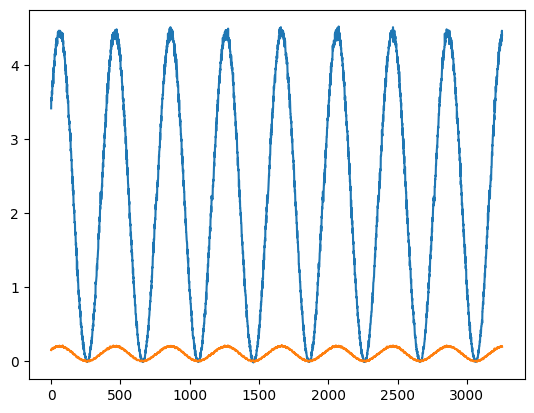

0.0007905694150420947
4050
Generating current of frequency 3.1622776601683795
fetching voltage
fetching current
Fetch successful


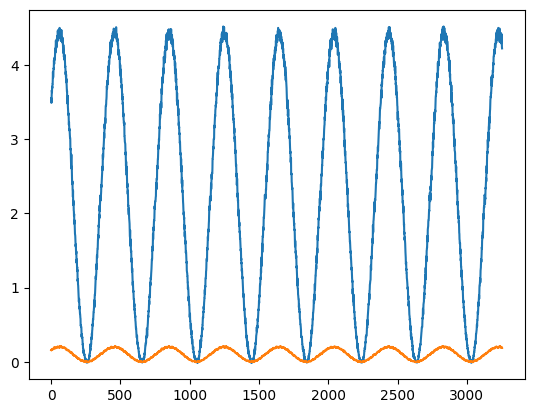

0.00025
850
Generating current of frequency 10.0
fetching voltage
fetching current
Fetch successful


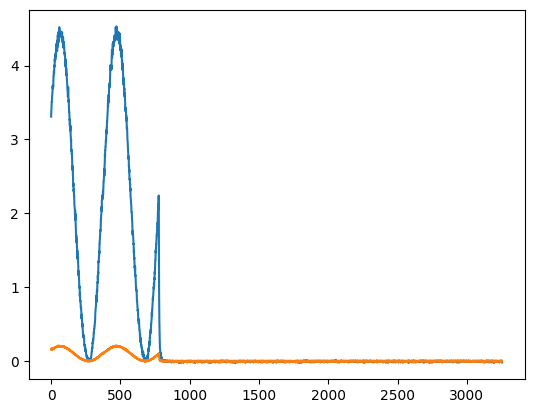

7.905694150420948e-05
850
Generating current of frequency 31.622776601683796
fetching voltage
fetching current
Fetch successful


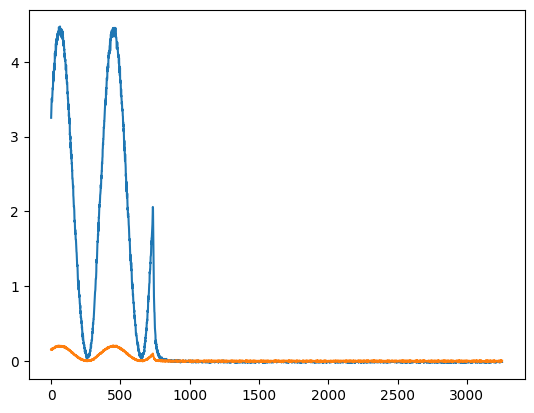

2.5e-05
16050
Generating current of frequency 100.0
fetching voltage
fetching current
Fetch successful


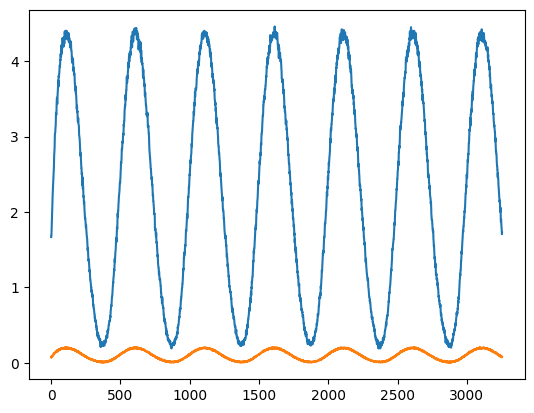

7.905694150420947e-06
16051
Generating current of frequency 316.22776601683796
fetching voltage
fetching current
Fetch successful


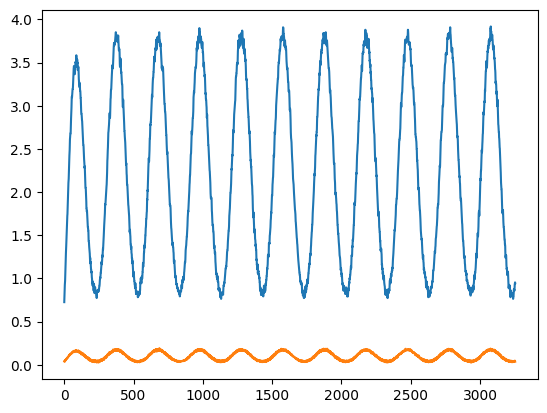

2.5e-06
16050
Generating current of frequency 1000
fetching voltage
fetching current
Fetch successful


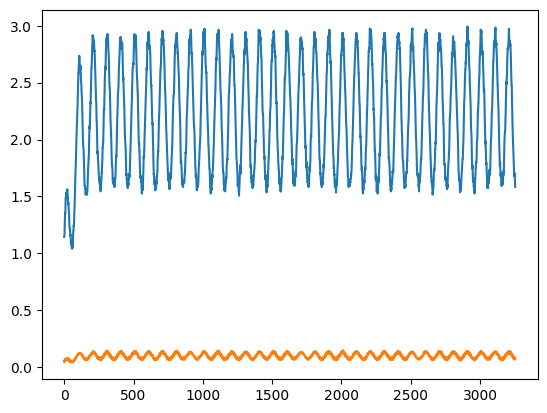

PermissionError: [Errno 13] Permission denied: 'output.csv'

In [122]:
initialFreq, finalFreq = (1, 1000)
sweep_points_per_decade = 2 
amplitude = 0.1 #A

inst = RP7972A(initialFreq, finalFreq, sweep_points_per_decade, amplitude)
inst.scpi_out("*RST")
inst.sweep_frequencies()
inst.voltage_limit=10
sweep_frequencies = inst.curr_Freqs
output_Data=[]

for frequency in sweep_frequencies:
    inst.config_arb(frequency)
    inst.measure_setup()
    #TODO: Test measure triggering with the tran trigger
    
    trigger_ready = False
    while not(trigger_ready):
        time.sleep(1)
        status = inst.status_check()
        trigger_ready =  status[4] and status[3] #WTG-meas and WTG-tran
    inst.scpi_out("*TRG") #Trigger for Arb and Meas

    
    status_arb = True
    print("Generating current of frequency " + str(frequency))
    while(status_arb):
        time.sleep(1) #Delay to check status
        status = inst.status_check()
        status_arb = int(status[1]) #TRAN-active
    inst.stop() #For Fetch
    inst.fetch()
    output_Data.append(["V "+str(frequency)]+inst.voltage_meas)
    plt.plot(range(len(inst.voltage_meas)),inst.voltage_meas,range(len(inst.current_meas)),inst.current_meas)
    plt.show()
    output_Data.append(["I "+str(frequency)]+inst.current_meas)
        
with open("output.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(output_Data)